<h2>Example 2: Persistent Contrail, Impose Saturation Depth</h2>
In this example, the ambient relative humidity is set to a value that allows a contrail to persist. When APCEMM knows that the contrail may persist, the results from EPM will be used as the inputs for the mature plume model (MPM). The MPM then runs until either the vast majority of ice crystals have subliminated, or the simulation time reaches the plume process time as specified in the input file (as is the case here). The contrail would otherwise persist for over 24 hours with these parameters.

<h4>Specifying Meteorological Conditions in APCEMM</h4>
To run APCEMM, the user must select at least one of "Use met input", "Impose moist layer depth", or "Impose lapse rate" in the Meteorology Menu. In this case, we have specified a supersaturated layer depth of 1000 meters. Imposing a moist layer depth will take precedent over imposing the lapse rate due to the conditions required to fulfill a specified depth. The use of meteorological input is discussed in Example 3.

In [1]:
#Import Libs and setup plotting settings
import os.path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#Functions that will be used for postprocessing
class apce_data_struct:
    def __init__(self, t, ds_t, icemass, h2omass, numparts):
        self.t = t
        self.ds_t = ds_t
        self.icemass = icemass
        self.h2omass = h2omass
        self.numparts = numparts
    
def read_apcemm_data(directory):
    t_mins = []
    ds_t = []
    ice_mass = []
    total_h2o_mass = []
    num_particles = []

    for file in sorted(os.listdir(directory)):
        if(file.startswith('ts_aerosol') and file.endswith('.nc')):
            file_path = os.path.join(directory,file)
            ds = xr.open_dataset(file_path, engine = "netcdf4", decode_times = False)
            ds_t.append(ds)
            tokens = file_path.split('.')
            mins = int(tokens[-2][-2:])
            hrs = int(tokens[-2][-4:-2])
            t_mins.append(hrs*60 + mins)

            ice_mass.append(ds["Ice Mass"])
            num_particles.append(ds["Number Ice Particles"])
            dx = abs(ds["x"][-1] - ds["x"][0])/len(ds["x"])
            dy = abs(ds["y"][-1] - ds["y"][0])/len(ds["y"])
            
            h2o_mass = np.sum(ds["H2O"]) * 1e6 / 6.022e23 * 0.018 * dx*dy + ds["Ice Mass"]
            total_h2o_mass.append(h2o_mass.values)
    return apce_data_struct(t_mins, ds_t, ice_mass, total_h2o_mass, num_particles)

def removeLow(arr, cutoff = 1e-3):
    func = lambda x: (x > cutoff) * x
    vfunc = np.vectorize(func)
    return vfunc(arr)

In [3]:
apce_data = read_apcemm_data('APCEMM_out/')
t = apce_data.t
ds_t = apce_data.ds_t
ice_mass = apce_data.icemass
total_h2o_mass = apce_data.h2omass


/home/xu990/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
No module named 'eccodes'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
#Let's take a look at the format of the data
ds_t[0]

<xarray.Dataset>
Dimensions:                      (x: 2048, y: 192, r_b: 39, r: 38, t: 1)
Coordinates:
  * x                            (x) float32 -4.998e+04 -4.993e+04 ... 4.998e+04
  * y                            (y) float32 -1.494e+03 -1.483e+03 ... 644.4
  * r                            (r) float32 5.541e-08 6.74e-08 ... 7.798e-05
  * t                            (t) float32 0.0
Dimensions without coordinates: r_b
Data variables: (12/20)
    r_e                          (r_b) float32 ...
    Pressure                     (y) float32 ...
    Altitude                     (y) float32 ...
    H2O                          (y, x) float32 5.762e+14 ... 2.846e+14
    Temperature                  (y, x) float32 ...
    Ice aerosol particle number  (y, x) float32 ...
    ...                           ...
    Extinction                   (y, x) float32 ...
    IWC                          (y, x) float32 ...
    RHi                          (y, x) float32 ...
    width                        (t) float32 ...
    depth                        (t) float32 ...
    intOD                        (t) float32 ...
Attributes:
    FileName:         /home/xu990/APCEMM_cmake/examples/Example2_Impose_Depth...
    Author:           Thibaud M. Fritz (fritzt@mit.edu)
    Contact:          Thibaud M. Fritz (fritzt@mit.edu)
    Generation Date:  16-10-2023 13:39:24
    Format:           NetCDF-4

In [5]:
#You can also look at specific coordinates or variables in the data and see properties such as the units
ds_t[0]["IWC"]

<xarray.DataArray 'IWC' (y: 192, x: 2048)>
[393216 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4.998e+04 -4.993e+04 ... 4.993e+04 4.998e+04
  * y        (y) float32 -1.494e+03 -1.483e+03 -1.472e+03 ... 622.0 633.2 644.4
Attributes:
    units:      kg / m^3
    long_name:  Ice Water Content

Text(0, 0.5, 'Ice Mass (kg/m)')

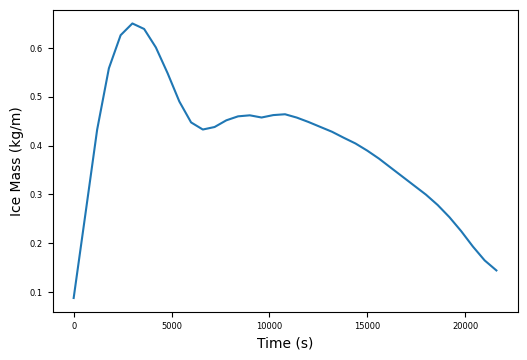

In [6]:
#Example of plotting variables that are a function of time, such as Ice Mass.
fig, axes = plt.subplots(dpi=100)
t_s = [i*60 for i in t]
axes.plot(t_s, ice_mass)
axes.set_xlabel("Time (s)")
axes.set_ylabel("Ice Mass (kg/m)")

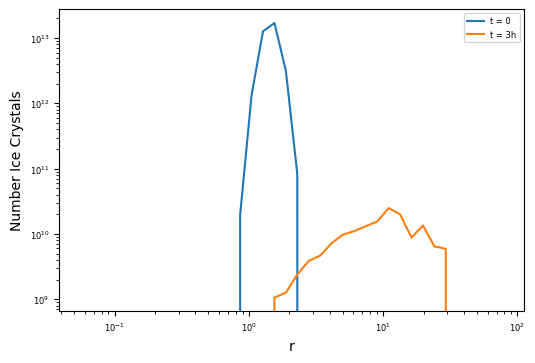

In [7]:
#Visualizing the evolution of the particle radius distribution over time
fig, axes = plt.subplots(dpi=100)
map=plt.plot(ds_t[0]['r'] * 1e6, removeLow(ds_t[0]["Overall size distribution"], cutoff = 1e9), label="t = 0")
map=plt.plot(ds_t[18]['r'] * 1e6, removeLow(ds_t[18]["Overall size distribution"], cutoff = 1e9), label="t = 3h")

axes.set_xlabel('r')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylabel('Number Ice Crystals')
plt.legend()
plt.show()

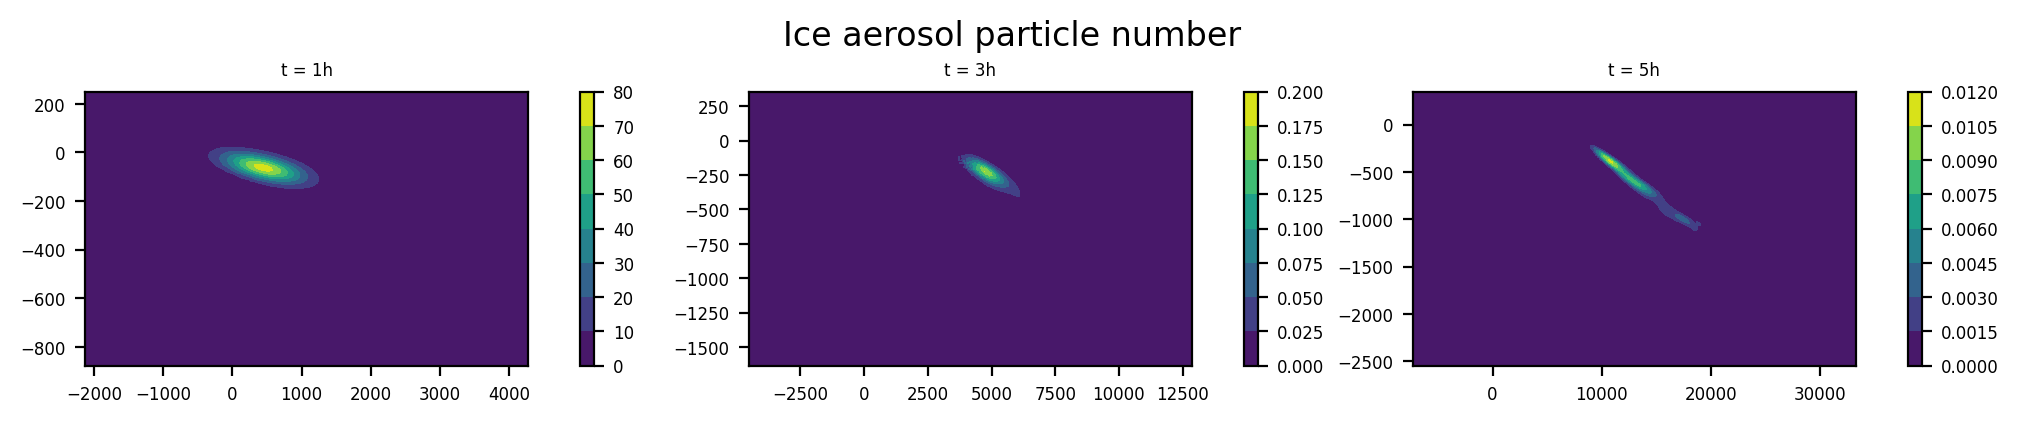

In [91]:
#Looking at some 2D contours over time (e.g. Ice aerosol particle number)
fig, ((ax11, ax12, ax13)) = plt.subplots(nrows = 1, ncols = 3, dpi=200, figsize=[10, 2])
fig.suptitle("Ice aerosol particle number")

ds_t_1h = ds_t[6]
X_map1h, Y_map1h = np.meshgrid(ds_t_1h["x"], ds_t_1h["y"])
map1h = ax11.contourf(X_map1h, Y_map1h, ds_t_1h['Ice aerosol particle number'])
ax11.set_title('t = 1h')
plt.colorbar(map1h, ax = ax11,fraction=0.046, pad=0.1)


ds_t_3h = ds_t[18]
X_map3h, Y_map3h = np.meshgrid(ds_t_3h["x"], ds_t_3h["y"])
map3h=ax12.contourf(X_map3h, Y_map3h, ds_t_3h['Ice aerosol particle number'])
ax12.set_title('t = 3h')
plt.colorbar(map3h, ax = ax12,fraction=0.046, pad=0.1)


ds_t_5h = ds_t[30]
X_map5h, Y_map5h = np.meshgrid(ds_t_5h["x"], ds_t_5h["y"])
map5h=ax13.contourf(X_map5h, Y_map5h, ds_t_5h['Ice aerosol particle number'])
ax13.set_title('t = 5h')
plt.colorbar(map5h, ax = ax13,fraction=0.046, pad=0.1)


fig.tight_layout(pad=0.3)

plt.show()

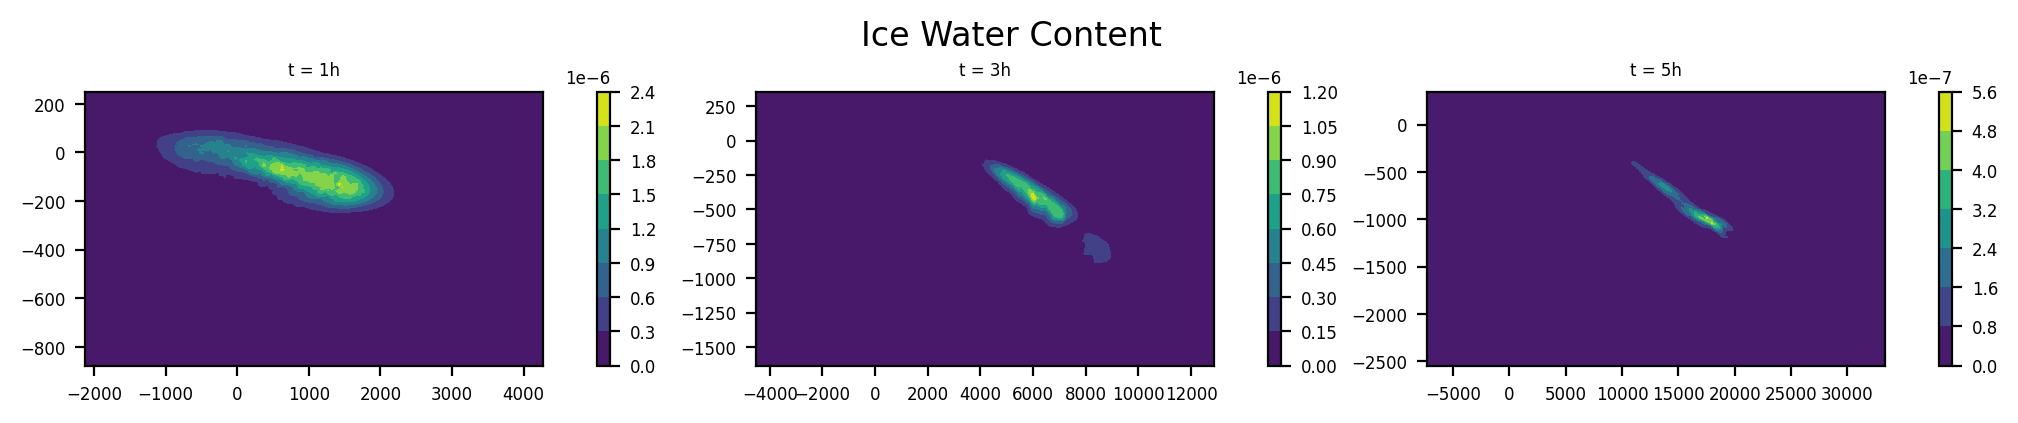

In [8]:
#Looking at a different 2D contour, IWC over time. Notice the contrast in ice particles vs ice mass distribution.
fig, ((ax11, ax12, ax13)) = plt.subplots(nrows = 1, ncols = 3, dpi=200, figsize=[10, 2])
fig.suptitle("Ice Water Content")

ds_t_1h = ds_t[6]
X_map1h, Y_map1h = np.meshgrid(ds_t_1h["x"], ds_t_1h["y"])
map1h = ax11.contourf(X_map1h, Y_map1h, ds_t_1h['IWC'])
ax11.set_title('t = 1h')
plt.colorbar(map1h, ax = ax11,fraction=0.046, pad=0.1)


ds_t_3h = ds_t[18]
X_map3h, Y_map3h = np.meshgrid(ds_t_3h["x"], ds_t_3h["y"])
map3h=ax12.contourf(X_map3h, Y_map3h, ds_t_3h['IWC'])
ax12.set_title('t = 3h')
plt.colorbar(map3h, ax = ax12,fraction=0.046, pad=0.1)


ds_t_5h = ds_t[30]
X_map5h, Y_map5h = np.meshgrid(ds_t_5h["x"], ds_t_5h["y"])
map5h=ax13.contourf(X_map5h, Y_map5h, ds_t_5h['IWC'])
ax13.set_title('t = 5h')
plt.colorbar(map5h, ax = ax13,fraction=0.046, pad=0.1)


fig.tight_layout(pad=0.3)

plt.show()